## SPARC-4 mini-pipeline tools
# Science image reduction

This notebook shows an example for reducing a series of scientific images using the SPARC4 pipeline.

* Eder Martioli, LNA 10 Jun 2023

In [1]:
import os,sys
path_parent = os.path.dirname(os.getcwd())
# path_parent = "/Volumes/Samsung_T5/sparc4-pipeline/"
sys.path.append(path_parent) 
import sparc4_pipeline_lib as s4pipelib
import sparc4_params

/Users/eder/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## User inputs

In [3]:
# set an object ID matching the ID in the image header keyword 'OBJECT'
OBJECTID = "all"

# set night directory name
NIGHTDIR = '20230503'
# set raw data root directory
DATADIR =  "/Volumes/Samsung_T5/Data/SPARC4/minidata/"
# set reduced data root directory
REDUCEDDIR = "/Volumes/Samsung_T5/Data/SPARC4/minidata/reduced/"

# set SPARC4 channel
CHANNEL = 3  # 1, 2, 3 or 4

# whether or not to force reduction even if product already exists
FORCE = False

# get SPARC4 pipeline parameters
p = sparc4_params.init_s4_p(datadir=DATADIR,
                            reducedir=REDUCEDDIR,
                            nightdir=NIGHTDIR,
                            channels="{}".format(CHANNEL),
                            print_report=False)

# uncomment below to set maximum number of files for stacking
p['NFILES_FOR_STACK'] = 16

## Define input calibrations
Here is where one should define the following calibrations:
* Master bias
* Master flat
* A file containing the reference WCS for an astrometric solution

In [4]:
# set master bias product file name
p["master_bias"] = "{}/{}_s4c{}_MasterZero.fits".format(p['reduce_directories'][CHANNEL-1],NIGHTDIR,CHANNEL)
# set master flat product file name
p["master_flat"] = "{}/{}_s4c{}_MasterDomeFlat.fits".format(p['reduce_directories'][CHANNEL-1],NIGHTDIR,CHANNEL)

# set reference image for astrometry
p["ASTROM_REF_IMG"] = p["ASTROM_REF_IMGS"][CHANNEL-1]

# Start reduction here

## 1. Reduce scientific exposures in `PHOTOMETRY` mode

0 Reference image: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_004298_cr1.fits
OBJECT files: 5
Loading science frames to memory ... 
gain: 0.8 electron / adu
Calibrating science frames (CR, gain, bias, flat) ... 
Calibrating science frame 1 of 5 : 20230503_s4c3_004298_cr1.fits 


/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  while col in self.keywords:


Calibrating science frame 2 of 5 : 20230503_s4c3_004299_cr1.fits 
Calibrating science frame 3 of 5 : 20230503_s4c3_004301_cr1.fits 
Calibrating science frame 4 of 5 : 20230503_s4c3_004300_cr1.fits 
Calibrating science frame 5 of 5 : 20230503_s4c3_004302_cr1.fits 


2023-06-11 03:34:21,062 astropop - INFO - Registering image 1 from 5  [register]
2023-06-11 03:34:21,076 astropop - INFO - Images are equal, skipping registering.  [register]
2023-06-11 03:34:21,164 astropop - INFO - Registering image 2 from 5  [register]


Registering science frames and stacking them ... 
0 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_004298_cr1.fits
1 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_004299_cr1.fits
2 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_004301_cr1.fits
3 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_004300_cr1.fits
4 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_004302_cr1.fits


2023-06-11 03:34:21,495 astropop - INFO - Filling registered image with cval=24.14  [register]
2023-06-11 03:34:21,496 astropop - INFO - Registering image with: translation=[-0.3686216  -0.30864211], rotation=-0.01°  [register]
2023-06-11 03:34:21,581 astropop - INFO - Registering image 3 from 5  [register]
2023-06-11 03:34:21,910 astropop - INFO - Filling registered image with cval=24.95  [register]
2023-06-11 03:34:21,911 astropop - INFO - Registering image with: translation=[-0.77019615 -0.13741129], rotation=-0.01°  [register]
2023-06-11 03:34:21,986 astropop - INFO - Registering image 4 from 5  [register]
2023-06-11 03:34:22,316 astropop - INFO - Filling registered image with cval=25.01  [register]
2023-06-11 03:34:22,317 astropop - INFO - Registering image with: translation=[-0.36108617  0.22385841], rotation=-0.01°  [register]
2023-06-11 03:34:22,404 astropop - INFO - Registering image 5 from 5  [register]
2023-06-11 03:34:22,738 astropop - INFO - Filling registered image with c

Creating new catalog of detected sources:
Running loop 0 of 1 -> images in loop: 0 to 5 ... 
OBJECT files: 5
Creating output list of processed science frames ... 
1 of 5 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_004298_cr1_proc.fits
2 of 5 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_004299_cr1_proc.fits
3 of 5 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_004300_cr1_proc.fits
4 of 5 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_004301_cr1_proc.fits
5 of 5 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_004302_cr1_proc.fits
Loading science frames to memory ... 


/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  while col in self.keywords:


gain: 0.8 electron / adu
Calibrating science frames (CR, gain, bias, flat) ... 
Calibrating science frame 1 of 5 : 20230503_s4c3_004298_cr1.fits 
Calibrating science frame 2 of 5 : 20230503_s4c3_004299_cr1.fits 
Calibrating science frame 3 of 5 : 20230503_s4c3_004300_cr1.fits 
Calibrating science frame 4 of 5 : 20230503_s4c3_004301_cr1.fits 
Calibrating science frame 5 of 5 : 20230503_s4c3_004302_cr1.fits 


2023-06-11 03:34:45,202 astropop - INFO - Computing shift of image 1 from 5  [register]
2023-06-11 03:34:45,203 astropop - INFO - Computing shift of image 2 from 5  [register]


Calculating offsets ... 
Computing offsets with respect to the reference image: index=0 -> /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_004298_cr1.fits


2023-06-11 03:34:45,485 astropop - INFO - Computing shift of image 3 from 5  [register]
2023-06-11 03:34:45,755 astropop - INFO - Computing shift of image 4 from 5  [register]
2023-06-11 03:34:46,038 astropop - INFO - Computing shift of image 5 from 5  [register]


Running aperture photometry for exiting catalogs offset by dx=0.0 dy=0.0
Saving frame 1 of 5: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_004298_cr1.fits -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_004298_cr1_proc.fits
Running aperture photometry for exiting catalogs offset by dx=-0.3686216042935371 dy=-0.3086421105781483
Saving frame 2 of 5: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_004299_cr1.fits -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_004299_cr1_proc.fits
Running aperture photometry for exiting catalogs offset by dx=-0.36108617185988123 dy=0.22385840621041098
Saving frame 3 of 5: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_004300_cr1.fits -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_004300_cr1_proc.fits
Running aperture photometry for exiting catalogs o

/Users/eder/anaconda3/lib/python3.7/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


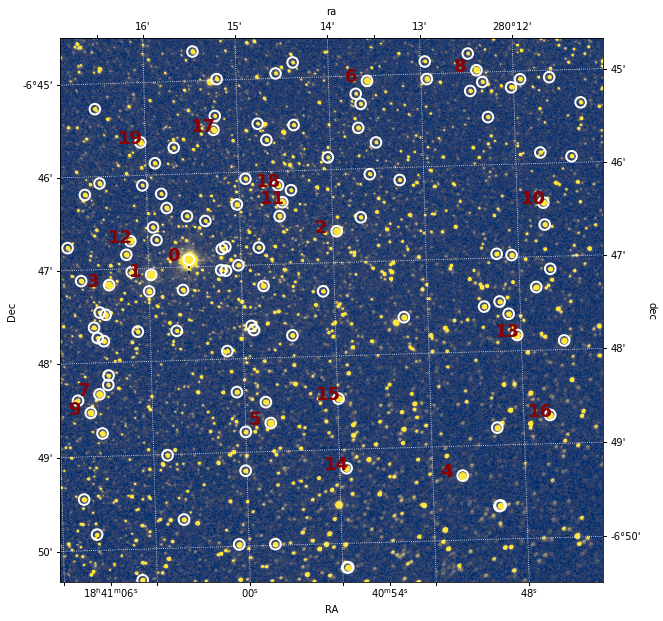

In [5]:
# loop over all objects observed in photometric mode
for obj in p['objsInPhot'][CHANNEL-1] :
    # reduce only a selected object or all objects 
    if obj == OBJECTID or OBJECTID == 'all':    
        # set suffix for stack product
        stack_suffix = "{}_s4c{}_{}".format(NIGHTDIR,p['CHANNELS'][CHANNEL-1],obj.replace(" ",""))

        # get full list of science objects in the current channel
        sci_list = p['objsInPhotdata'][CHANNEL-1][obj]

        # run stack and reduce individual science images (produce *_proc.fits)
        p = s4pipelib.stack_and_reduce_sci_images(p,
                                                  sci_list,
                                                  p['reduce_directories'][CHANNEL-1],
                                                  stack_suffix=stack_suffix,
                                                  force=FORCE,
                                                  match_frames=True,
                                                  polarimetry=False,
                                                  verbose=True,
                                                  plot=True)

## 2. Reduce scientific exposures in `POLARIMETRY HALF-WAVE` mode

14 Reference image: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002590_hd111.fits
OBJECT files: 5
Loading science frames to memory ... 
gain: 0.8 electron / adu
Calibrating science frames (CR, gain, bias, flat) ... 
Calibrating science frame 1 of 5 : 20230503_s4c3_002590_hd111.fits 


/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  while col in self.keywords:


Calibrating science frame 2 of 5 : 20230503_s4c3_002591_hd111.fits 
Calibrating science frame 3 of 5 : 20230503_s4c3_002581_hd111.fits 
Calibrating science frame 4 of 5 : 20230503_s4c3_002582_hd111.fits 
Calibrating science frame 5 of 5 : 20230503_s4c3_002586_hd111.fits 


2023-06-11 03:35:37,676 astropop - INFO - Registering image 1 from 5  [register]
2023-06-11 03:35:37,689 astropop - INFO - Images are equal, skipping registering.  [register]
2023-06-11 03:35:37,763 astropop - INFO - Registering image 2 from 5  [register]


Registering science frames and stacking them ... 
0 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002590_hd111.fits
1 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002591_hd111.fits
2 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002581_hd111.fits
3 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002582_hd111.fits
4 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002586_hd111.fits


2023-06-11 03:35:38,027 astropop - INFO - Filling registered image with cval=11.01  [register]
2023-06-11 03:35:38,028 astropop - INFO - Registering image with: translation=[ 0.23495678 -0.17818184], rotation=-0.02°  [register]
2023-06-11 03:35:38,106 astropop - INFO - Registering image 3 from 5  [register]
2023-06-11 03:35:38,358 astropop - INFO - Filling registered image with cval=10.92  [register]
2023-06-11 03:35:38,358 astropop - INFO - Registering image with: translation=[-0.65914334  0.67489406], rotation=0.00°  [register]
2023-06-11 03:35:38,442 astropop - INFO - Registering image 4 from 5  [register]
2023-06-11 03:35:38,689 astropop - INFO - Filling registered image with cval=10.97  [register]
2023-06-11 03:35:38,690 astropop - INFO - Registering image with: translation=[-0.31140544  0.3620728 ], rotation=0.00°  [register]
2023-06-11 03:35:38,771 astropop - INFO - Registering image 5 from 5  [register]
2023-06-11 03:35:39,020 astropop - INFO - Filling registered image with cva

Creating new catalog of detected sources:
Running loop 0 of 1 -> images in loop: 0 to 16 ... 


/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  while col in self.keywords:


OBJECT files: 16
Creating output list of processed science frames ... 
1 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002576_hd111_proc.fits
2 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002577_hd111_proc.fits
3 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002578_hd111_proc.fits
4 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002579_hd111_proc.fits
5 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002580_hd111_proc.fits
6 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002581_hd111_proc.fits
7 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/2023050

2023-06-11 03:36:07,090 astropop - INFO - Computing shift of image 1 from 16  [register]


Calculating offsets ... 
Computing offsets with respect to the reference image: index=14 -> /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002590_hd111.fits


2023-06-11 03:36:07,304 astropop - INFO - Computing shift of image 2 from 16  [register]
2023-06-11 03:36:07,500 astropop - INFO - Computing shift of image 3 from 16  [register]
2023-06-11 03:36:07,703 astropop - INFO - Computing shift of image 4 from 16  [register]
2023-06-11 03:36:07,905 astropop - INFO - Computing shift of image 5 from 16  [register]
2023-06-11 03:36:08,098 astropop - INFO - Computing shift of image 6 from 16  [register]
2023-06-11 03:36:08,302 astropop - INFO - Computing shift of image 7 from 16  [register]
2023-06-11 03:36:08,511 astropop - INFO - Computing shift of image 8 from 16  [register]
2023-06-11 03:36:08,713 astropop - INFO - Computing shift of image 9 from 16  [register]
2023-06-11 03:36:08,919 astropop - INFO - Computing shift of image 10 from 16  [register]
2023-06-11 03:36:09,116 astropop - INFO - Computing shift of image 11 from 16  [register]
2023-06-11 03:36:09,327 astropop - INFO - Computing shift of image 12 from 16  [register]
2023-06-11 03:36:0

Running aperture photometry for exiting catalogs offset by dx=-0.5116246239772408 dy=0.6702893091237456
Saving frame 1 of 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002576_hd111.fits -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002576_hd111_proc.fits
Running aperture photometry for exiting catalogs offset by dx=-0.5618972833947851 dy=0.2545623362278775
Saving frame 2 of 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002577_hd111.fits -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002577_hd111_proc.fits
Running aperture photometry for exiting catalogs offset by dx=-1.0302647819947879 dy=0.1961169362821238
Saving frame 3 of 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002578_hd111.fits -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002578_hd111_proc.fits
Running

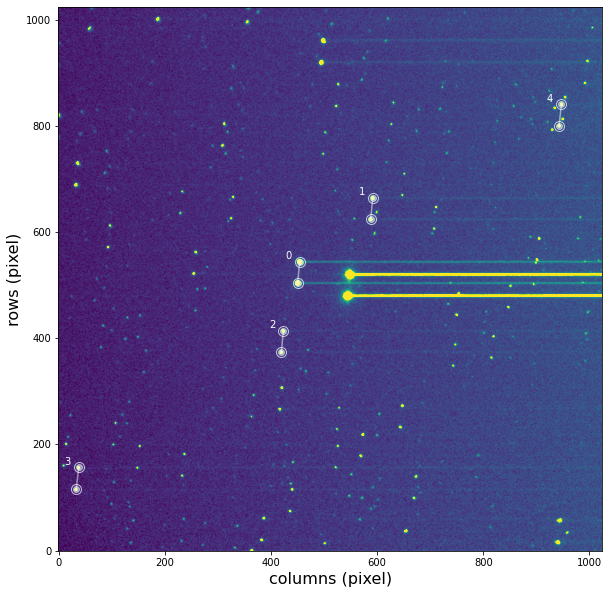

In [6]:
for obj in p['objsInPolarl2'][CHANNEL-1] :
    if obj == OBJECTID or OBJECTID == 'all':
        # set suffix for stack product        
        stack_suffix = "{}_s4c{}_{}_POL_L2".format(NIGHTDIR,p['CHANNELS'][CHANNEL-1],obj.replace(" ",""))
        
        # get full list of science objects in the current channel
        sci_list = p['objsInPolarL2data'][CHANNEL-1][obj]
        
        # run stack and reduce individual science images (produce *_proc.fits)
        p = s4pipelib.stack_and_reduce_sci_images(p,
                                                  sci_list,
                                                  p['reduce_directories'][CHANNEL-1],
                                                  stack_suffix=stack_suffix,
                                                  force=FORCE,
                                                  match_frames=True,
                                                  polarimetry=True,
                                                  verbose=True,
                                                  plot=True)

## 3. Reduce scientific exposures in `POLARIMETRY QUARTER-WAVE` mode

9 Reference image: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002601_hd1l4.fits
OBJECT files: 5
Loading science frames to memory ... 
gain: 0.8 electron / adu
Calibrating science frames (CR, gain, bias, flat) ... 
Calibrating science frame 1 of 5 : 20230503_s4c3_002601_hd1l4.fits 


/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  while col in self.keywords:


Calibrating science frame 2 of 5 : 20230503_s4c3_002595_hd1l4.fits 
Calibrating science frame 3 of 5 : 20230503_s4c3_002602_hd1l4.fits 
Calibrating science frame 4 of 5 : 20230503_s4c3_002599_hd1l4.fits 
Calibrating science frame 5 of 5 : 20230503_s4c3_002600_hd1l4.fits 


2023-06-11 03:37:12,120 astropop - INFO - Registering image 1 from 5  [register]
2023-06-11 03:37:12,132 astropop - INFO - Images are equal, skipping registering.  [register]
2023-06-11 03:37:12,208 astropop - INFO - Registering image 2 from 5  [register]


Registering science frames and stacking them ... 
0 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002601_hd1l4.fits
1 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002595_hd1l4.fits
2 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002602_hd1l4.fits
3 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002599_hd1l4.fits
4 /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002600_hd1l4.fits


2023-06-11 03:37:12,468 astropop - INFO - Filling registered image with cval=10.89  [register]
2023-06-11 03:37:12,468 astropop - INFO - Registering image with: translation=[-0.12044992  0.73856524], rotation=-0.01°  [register]
2023-06-11 03:37:12,550 astropop - INFO - Registering image 3 from 5  [register]
2023-06-11 03:37:12,806 astropop - INFO - Filling registered image with cval=10.90  [register]
2023-06-11 03:37:12,807 astropop - INFO - Registering image with: translation=[0.11813719 0.52129219], rotation=0.00°  [register]
2023-06-11 03:37:12,889 astropop - INFO - Registering image 4 from 5  [register]
2023-06-11 03:37:13,267 astropop - INFO - Filling registered image with cval=10.96  [register]
2023-06-11 03:37:13,267 astropop - INFO - Registering image with: translation=[-0.24619817  0.96825355], rotation=-0.01°  [register]
2023-06-11 03:37:13,344 astropop - INFO - Registering image 5 from 5  [register]
2023-06-11 03:37:13,582 astropop - INFO - Filling registered image with cval

Creating new catalog of detected sources:
Running loop 0 of 1 -> images in loop: 0 to 16 ... 


/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/_db.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  while col in self.keywords:


OBJECT files: 16
Creating output list of processed science frames ... 
1 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002592_hd1l4_proc.fits
2 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002593_hd1l4_proc.fits
3 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002594_hd1l4_proc.fits
4 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002595_hd1l4_proc.fits
5 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002596_hd1l4_proc.fits
6 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002597_hd1l4_proc.fits
7 of 16 is reduced? False -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/2023050

2023-06-11 03:37:41,343 astropop - INFO - Computing shift of image 1 from 16  [register]


Calculating offsets ... 
Computing offsets with respect to the reference image: index=9 -> /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002601_hd1l4.fits


2023-06-11 03:37:41,541 astropop - INFO - Computing shift of image 2 from 16  [register]
2023-06-11 03:37:41,733 astropop - INFO - Computing shift of image 3 from 16  [register]
2023-06-11 03:37:41,924 astropop - INFO - Computing shift of image 4 from 16  [register]
2023-06-11 03:37:42,120 astropop - INFO - Computing shift of image 5 from 16  [register]
2023-06-11 03:37:42,311 astropop - INFO - Computing shift of image 6 from 16  [register]
2023-06-11 03:37:42,502 astropop - INFO - Computing shift of image 7 from 16  [register]
2023-06-11 03:37:42,689 astropop - INFO - Computing shift of image 8 from 16  [register]
2023-06-11 03:37:42,883 astropop - INFO - Computing shift of image 9 from 16  [register]
2023-06-11 03:37:43,072 astropop - INFO - Computing shift of image 10 from 16  [register]
2023-06-11 03:37:43,073 astropop - INFO - Computing shift of image 11 from 16  [register]
2023-06-11 03:37:43,258 astropop - INFO - Computing shift of image 12 from 16  [register]
2023-06-11 03:37:4

Running aperture photometry for exiting catalogs offset by dx=0.9524881897074238 dy=1.0232112694926059
Saving frame 1 of 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002592_hd1l4.fits -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002592_hd1l4_proc.fits
Running aperture photometry for exiting catalogs offset by dx=0.8323870474383739 dy=1.2318388691539894
Saving frame 2 of 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002593_hd1l4.fits -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002593_hd1l4_proc.fits
Running aperture photometry for exiting catalogs offset by dx=0.3547926254125855 dy=0.5454434272845674
Saving frame 3 of 16: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs3/20230503/20230503_s4c3_002594_hd1l4.fits -> /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs3//20230503/20230503_s4c3_002594_hd1l4_proc.fits
Running ap

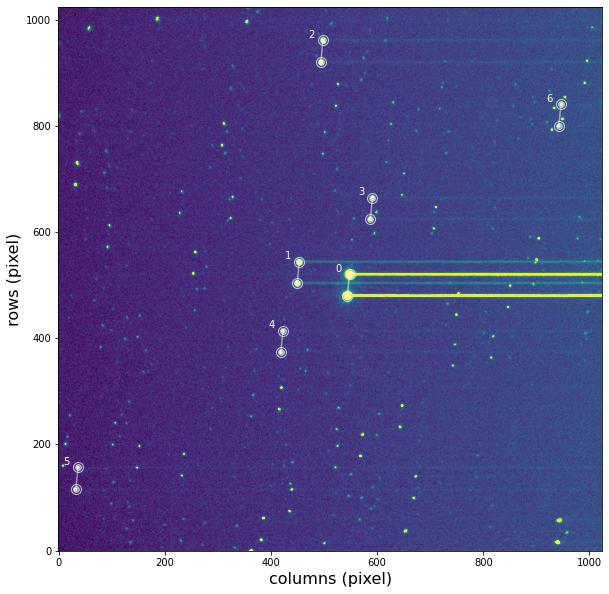

In [7]:
for obj in p['objsInPolarl4'][CHANNEL-1] :
    if obj == OBJECTID or OBJECTID == 'all':  
        # set suffix for stack product                
        stack_suffix = "{}_s4c{}_{}_POL_L4".format(NIGHTDIR,p['CHANNELS'][CHANNEL-1],obj.replace(" ",""))

        # get full list of science objects in the current channel
        sci_list = p['objsInPolarL4data'][CHANNEL-1][obj]        
        
        # run stack and reduce individual science images (produce *_proc.fits)
        p = s4pipelib.stack_and_reduce_sci_images(p,
                                                  sci_list,
                                                  p['reduce_directories'][CHANNEL-1],
                                                  stack_suffix=stack_suffix,
                                                  force=FORCE,
                                                  match_frames=True,
                                                  polarimetry=True,
                                                  verbose=True,
                                                  plot=True)